# Sri Lanka 2024 Census - Complete Data Analysis

This notebook analyzes GN-level population data from the 2024 Sri Lanka Census.

## Table of Contents
1. Data Loading & Overview
2. Sex Ratio Analysis
3. Dependency Ratio Analysis
4. District Summary
5. K-Means Clustering
6. Resource Allocation Index
7. Anomaly Detection

In [16]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading & Overview

In [17]:
# Load the cleaned data
df = pd.read_csv('../data/processed/GN_population_cleaned.csv')

# Clean column names (remove newlines if any)
df.columns = [col.replace('\n', '_') for col in df.columns]

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset Shape: (14008, 17)

Columns: ['Province_Code', 'Province_Name', 'District_Code', 'District_Name', 'DS_Division_Code', 'DS_Division_Name', 'GN_Division_Code', 'GN_Division_Name', 'GN_Division_Number', 'Sex_Total', 'Sex_Male', 'Sex_Female', 'Age_Total', 'Age_0_to_14', 'Age_15_to_59', 'Age_60_to_64', 'Age_65_and_above']


,Province_Code,Province_Name,District_Code,District_Name,DS_Division_Code,DS_Division_Name,GN_Division_Code,GN_Division_Name,GN_Division_Number,Sex_Total,Sex_Male,Sex_Female,Age_Total,Age_0_to_14,Age_15_to_59,Age_60_to_64,Age_65_and_above
0,1,Western,11,Colombo,3,Colombo,5,Sammanthranapura,,7640,3864,3776,7640,1695,4891,393,661
1,1,Western,11,Colombo,3,Colombo,10,Mattakkuliya,,28135,13749,14386,28135,5653,18163,1499,2820
2,1,Western,11,Colombo,3,Colombo,15,Modara,,31728,15579,16149,31728,6930,20400,1554,2844
3,1,Western,11,Colombo,3,Colombo,20,Madampitiya,,7699,3890,3809,7699,1831,5024,353,491
4,1,Western,11,Colombo,3,Colombo,25,Mahawatta,,7108,3611,3497,7108,1504,4582,354,668


In [18]:
# Data Info
print("Data Types:")
print(df.dtypes)
print(f"\nMissing Values:")
print(df.isnull().sum())

Data Types:
Province_Code         int64
Province_Name           str
District_Code         int64
District_Name           str
DS_Division_Code      int64
DS_Division_Name        str
GN_Division_Code      int64
GN_Division_Name        str
GN_Division_Number      str
Sex_Total             int64
Sex_Male              int64
Sex_Female            int64
Age_Total             int64
Age_0_to_14           int64
Age_15_to_59          int64
Age_60_to_64          int64
Age_65_and_above      int64
dtype: object

Missing Values:
Province_Code         0
Province_Name         0
District_Code         0
District_Name         0
DS_Division_Code      0
DS_Division_Name      0
GN_Division_Code      0
GN_Division_Name      0
GN_Division_Number    0
Sex_Total             0
Sex_Male              0
Sex_Female            0
Age_Total             0
Age_0_to_14           0
Age_15_to_59          0
Age_60_to_64          0
Age_65_and_above      0
dtype: int64


## 2. Sex Ratio Analysis

**Sex Ratio** = (Number of Males / Number of Females) * 100

A ratio of 100 means equal males and females.

In [19]:
# Identify correct column names
male_col = [c for c in df.columns if 'Male' in c and 'Female' not in c][0]
female_col = [c for c in df.columns if 'Female' in c][0]
gn_name_col = [c for c in df.columns if 'GN_Division' in c and 'Name' in c][0]
district_col = [c for c in df.columns if 'District' in c and 'Name' in c][0]
province_col = [c for c in df.columns if 'Province' in c and 'Name' in c][0]

print(f"Male: {male_col}, Female: {female_col}")

# Calculate Sex Ratio
df['Sex_Ratio'] = (df[male_col] / df[female_col].replace(0, np.nan)) * 100
print("\nSex Ratio Statistics:")
print(df['Sex_Ratio'].describe())

Male: Sex_Male, Female: Sex_Female

Sex Ratio Statistics:
count    14002.000000
mean        93.722704
std         11.216291
min         30.754950
25%         89.254386
50%         93.385729
75%         97.647059
max        894.915254
Name: Sex_Ratio, dtype: float64


In [20]:
# Identify GNs with extreme sex ratios
extreme_male = df[df['Sex_Ratio'] > 120].sort_values('Sex_Ratio', ascending=False)
extreme_female = df[df['Sex_Ratio'] < 80].sort_values('Sex_Ratio')

print(f"GN Divisions with Male Majority (Ratio > 120): {len(extreme_male)}")
print(extreme_male[[gn_name_col, district_col, 'Sex_Ratio']].head(10))

print(f"\nGN Divisions with Female Majority (Ratio < 80): {len(extreme_female)}")
print(extreme_female[[gn_name_col, district_col, 'Sex_Ratio']].head(10))

GN Divisions with Male Majority (Ratio > 120): 76
               GN_Division_Name District_Name   Sex_Ratio
22                       Pettah       Colombo  894.915254
4034           Divulgas Pathana        Matale  500.000000
3809                  Thalagoda        Matale  350.000000
10438              Palliyawatta      Puttalam  228.846154
9700   Kurunegala Town - Bazaar    Kurunegala  226.666667
3405                Ketakumbura         Kandy  224.534687
6404                Eraminiyaya    Hambantota  206.021505
7436                  Poomaduwa      Vavuniya  200.000000
3038                 Mahanuwara         Kandy  188.416076
10468                 Pukkulama      Puttalam  185.185185

GN Divisions with Female Majority (Ratio < 80): 343
          GN_Division_Name District_Name  Sex_Ratio
1663           Warakanatta       Gampaha  30.754950
6159      Meddawatta South        Matara  32.626798
3053      Palle Peradeniya         Kandy  35.029172
8410             Oluvil 01        Ampara  45.088317

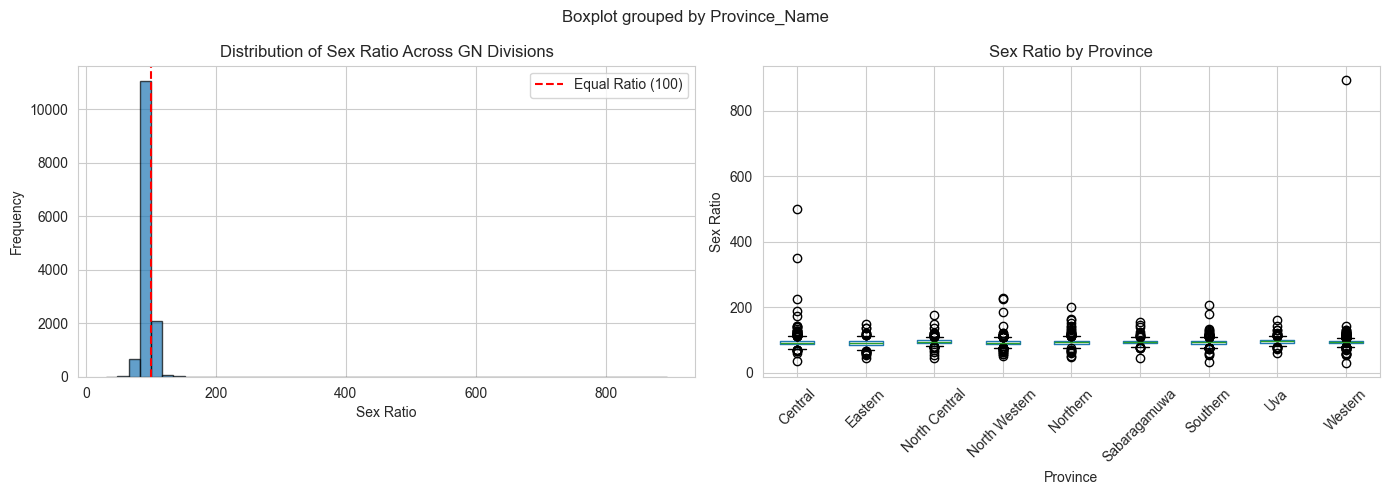

In [21]:
# Visualize Sex Ratio Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['Sex_Ratio'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(100, color='red', linestyle='--', label='Equal Ratio (100)')
axes[0].set_xlabel('Sex Ratio')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sex Ratio Across GN Divisions')
axes[0].legend()

df.boxplot(column='Sex_Ratio', by=province_col, ax=axes[1], rot=45)
axes[1].set_title('Sex Ratio by Province')
axes[1].set_xlabel('Province')
axes[1].set_ylabel('Sex Ratio')

plt.tight_layout()
plt.savefig('sex_ratio_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Dependency Ratio Analysis

**Child Dependency Ratio** = (Population aged 0-14 / Population aged 15-59) * 100

**Old-Age Dependency Ratio** = (Population aged 60+ / Population aged 15-59) * 100

In [22]:
# Find age group columns
child_col = [c for c in df.columns if '0_to_14' in c or '0-14' in c or '0_14' in c]
working_col = [c for c in df.columns if '15_to_59' in c or '15-59' in c or '15_59' in c]
elderly_60_64 = [c for c in df.columns if '60_to_64' in c or '60-64' in c or '60_64' in c]
elderly_65_plus = [c for c in df.columns if '65' in c and 'above' in c.lower()]

print(f"Child: {child_col}")
print(f"Working: {working_col}")
print(f"Elderly 60-64: {elderly_60_64}")
print(f"Elderly 65+: {elderly_65_plus}")

Child: ['Age_0_to_14']
Working: ['Age_15_to_59']
Elderly 60-64: ['Age_60_to_64']
Elderly 65+: ['Age_65_and_above']


In [23]:
# Calculate Dependency Ratios
try:
    child_pop = df[child_col[0]] if child_col else 0
    working_pop = df[working_col[0]] if working_col else 1
    elderly_60 = df[elderly_60_64[0]] if elderly_60_64 else 0
    elderly_65 = df[elderly_65_plus[0]] if elderly_65_plus else 0
    
    df['Child_Dependency_Ratio'] = (child_pop / working_pop.replace(0, np.nan)) * 100
    df['Old_Age_Dependency_Ratio'] = ((elderly_60 + elderly_65) / working_pop.replace(0, np.nan)) * 100
    df['Total_Dependency_Ratio'] = df['Child_Dependency_Ratio'] + df['Old_Age_Dependency_Ratio']
    
    print("Child Dependency Ratio Statistics:")
    print(df['Child_Dependency_Ratio'].describe())
    print("\nOld-Age Dependency Ratio Statistics:")
    print(df['Old_Age_Dependency_Ratio'].describe())
except Exception as e:
    print(f"Error: {e}")

Child Dependency Ratio Statistics:
count    14002.000000
mean        34.452472
std          6.557386
min          0.000000
25%         30.292268
50%         33.983833
75%         38.085669
max         70.902394
Name: Child_Dependency_Ratio, dtype: float64

Old-Age Dependency Ratio Statistics:
count    14002.000000
mean        31.402164
std          8.001872
min          0.000000
25%         26.340655
50%         31.419224
75%         36.290087
max        106.896552
Name: Old_Age_Dependency_Ratio, dtype: float64


In [24]:
# Top 10 GNs needing elder care and schools
print("Top 10 GN Divisions with Highest Old-Age Dependency (Elderly Care Priority):")
print(df.nlargest(10, 'Old_Age_Dependency_Ratio')[[gn_name_col, district_col, 'Old_Age_Dependency_Ratio']])

print("\nTop 10 GN Divisions with Highest Child Dependency (School Priority):")
print(df.nlargest(10, 'Child_Dependency_Ratio')[[gn_name_col, district_col, 'Child_Dependency_Ratio']])

Top 10 GN Divisions with Highest Old-Age Dependency (Elderly Care Priority):
            GN_Division_Name District_Name  Old_Age_Dependency_Ratio
7044                Kapputhu        Jaffna                106.896552
4034        Divulgas Pathana        Matale                100.000000
8607         Thennaimaravady   Trincomalee                 90.769231
7243  Pungudutivu South East        Jaffna                 89.473684
4414              Okandagala  Nuwara Eliya                 88.235294
7732              Iranaitivu   Kilinochchi                 85.714286
6800              Kotuwegoda    Hambantota                 80.147059
4036                Kahagala        Matale                 76.271186
6171          Pathegama East        Matara                 70.744681
4444               Batagolla  Nuwara Eliya                 70.588235

Top 10 GN Divisions with Highest Child Dependency (School Priority):
             GN_Division_Name District_Name  Child_Dependency_Ratio
636            Air Force C

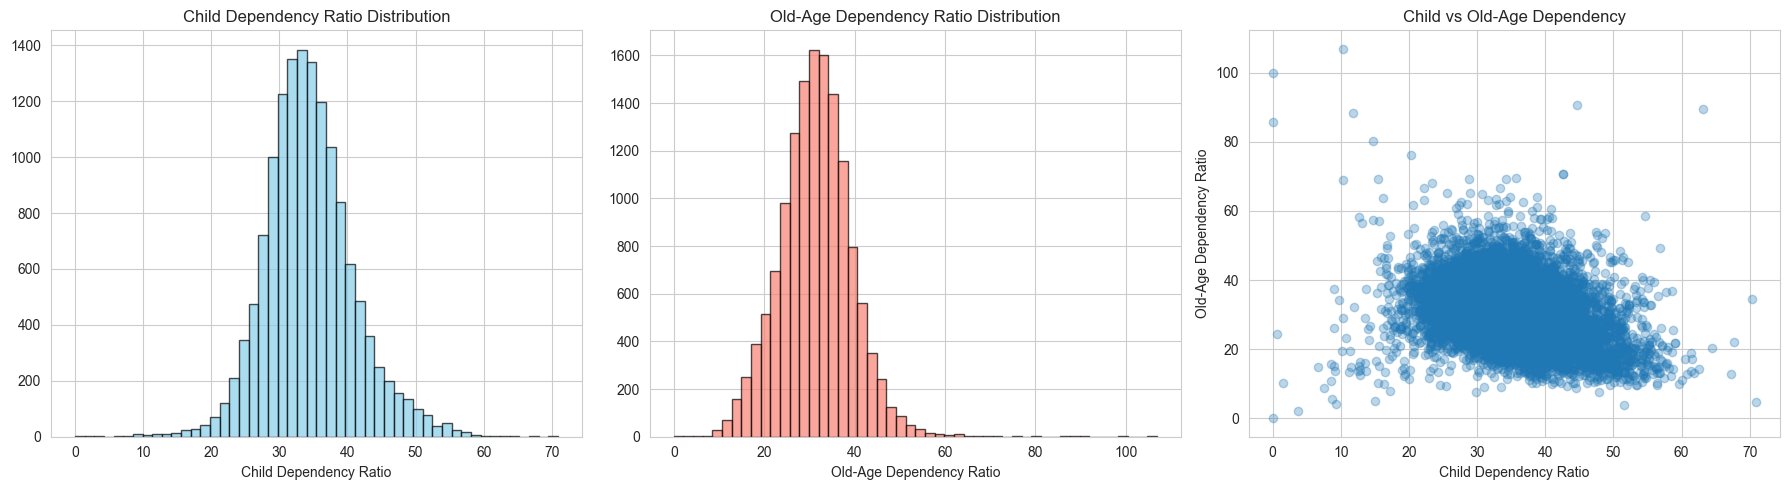

In [25]:
# Visualize Dependency Ratios
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df['Child_Dependency_Ratio'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Child Dependency Ratio')
axes[0].set_title('Child Dependency Ratio Distribution')

axes[1].hist(df['Old_Age_Dependency_Ratio'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='salmon')
axes[1].set_xlabel('Old-Age Dependency Ratio')
axes[1].set_title('Old-Age Dependency Ratio Distribution')

axes[2].scatter(df['Child_Dependency_Ratio'], df['Old_Age_Dependency_Ratio'], alpha=0.3)
axes[2].set_xlabel('Child Dependency Ratio')
axes[2].set_ylabel('Old-Age Dependency Ratio')
axes[2].set_title('Child vs Old-Age Dependency')

plt.tight_layout()
plt.savefig('dependency_ratio_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. District Summary

In [26]:
# Aggregate by District
district_summary = df.groupby(district_col).agg({
    'Sex_Ratio': 'mean',
    'Child_Dependency_Ratio': 'mean',
    'Old_Age_Dependency_Ratio': 'mean',
    gn_name_col: 'count'
}).rename(columns={gn_name_col: 'GN_Count'}).round(2)

district_summary = district_summary.sort_values('Old_Age_Dependency_Ratio', ascending=False)
print("District-Level Summary (Sorted by Old-Age Dependency):")
print(district_summary)

District-Level Summary (Sorted by Old-Age Dependency):
               Sex_Ratio  Child_Dependency_Ratio  Old_Age_Dependency_Ratio  \
District_Name                                                                
Kegalle            91.66                   32.87                     37.11   
Matara             92.61                   35.22                     36.26   
Kandy              92.57                   35.34                     34.78   
Galle              92.98                   32.70                     34.52   
Jaffna             90.38                   32.63                     34.33   
Nuwara Eliya       91.98                   38.06                     34.06   
Kurunegala         92.96                   34.43                     34.03   
Matale             96.69                   36.15                     33.89   
Hambantota         95.40                   37.47                     32.80   
Kalutara           93.61                   31.20                     31.98   
Gampaha  

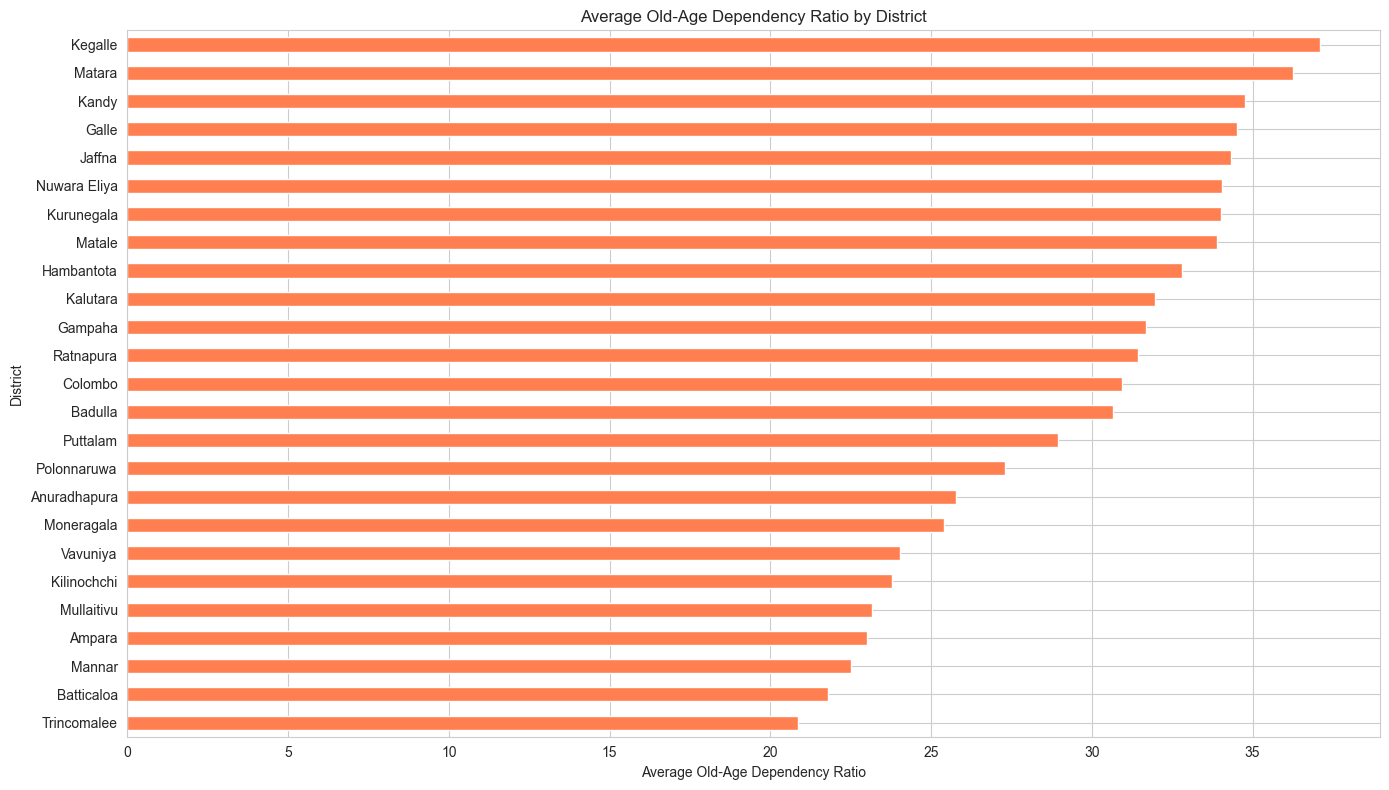

In [27]:
# Visualize District Summary
plt.figure(figsize=(14, 8))
district_summary['Old_Age_Dependency_Ratio'].sort_values().plot(kind='barh', color='coral')
plt.xlabel('Average Old-Age Dependency Ratio')
plt.ylabel('District')
plt.title('Average Old-Age Dependency Ratio by District')
plt.tight_layout()
plt.savefig('district_old_age_dependency.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Phase 5: Advanced Analytics & Modeling

## 5. K-Means Clustering (Demographic Profiles)

In [28]:
# Prepare features for clustering
features = ['Sex_Ratio', 'Child_Dependency_Ratio', 'Old_Age_Dependency_Ratio']
df_cluster = df[features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

print(f"Clustering {len(df_cluster)} GN divisions...")

Clustering 14001 GN divisions...


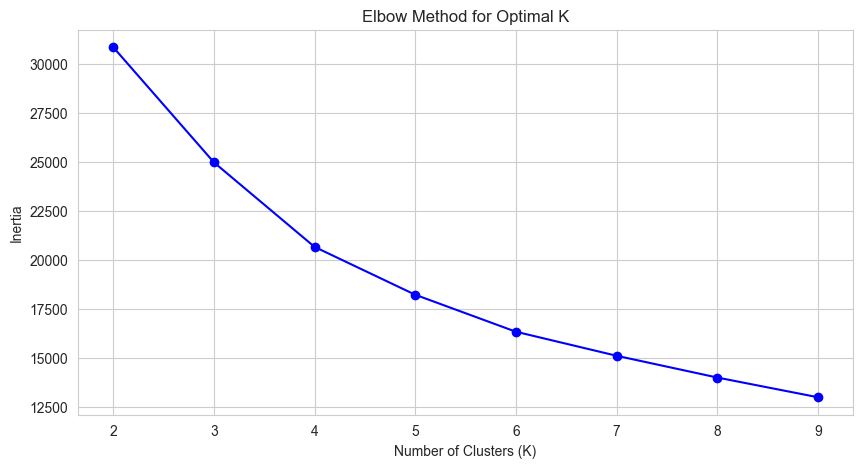

In [29]:
# Elbow Method for Optimal K
inertias = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.savefig('elbow_method.png', dpi=150, bbox_inches='tight')
plt.show()

In [30]:
# Apply K-Means with K=4
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df.loc[df_cluster.index, 'Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster Profile Analysis
cluster_profiles = df.groupby('Cluster')[features].mean().round(2)
print("Cluster Profiles (Mean Values):")
print(cluster_profiles)

# Assign Profile Names
profile_names = {
    cluster_profiles['Old_Age_Dependency_Ratio'].idxmax(): 'Aging Villages',
    cluster_profiles['Child_Dependency_Ratio'].idxmax(): 'Young Families',
    cluster_profiles['Sex_Ratio'].idxmax(): 'Male-Dominated',
    cluster_profiles['Sex_Ratio'].idxmin(): 'Female-Dominated'
}
df['Profile'] = df['Cluster'].map(lambda x: profile_names.get(x, f'Profile_{x}'))

Cluster Profiles (Mean Values):
         Sex_Ratio  Child_Dependency_Ratio  Old_Age_Dependency_Ratio
Cluster                                                             
0.0          90.78                   33.41                     39.70
1.0          94.51                   41.28                     24.62
2.0          95.36                   30.11                     29.68
3.0         697.46                    0.32                     62.13


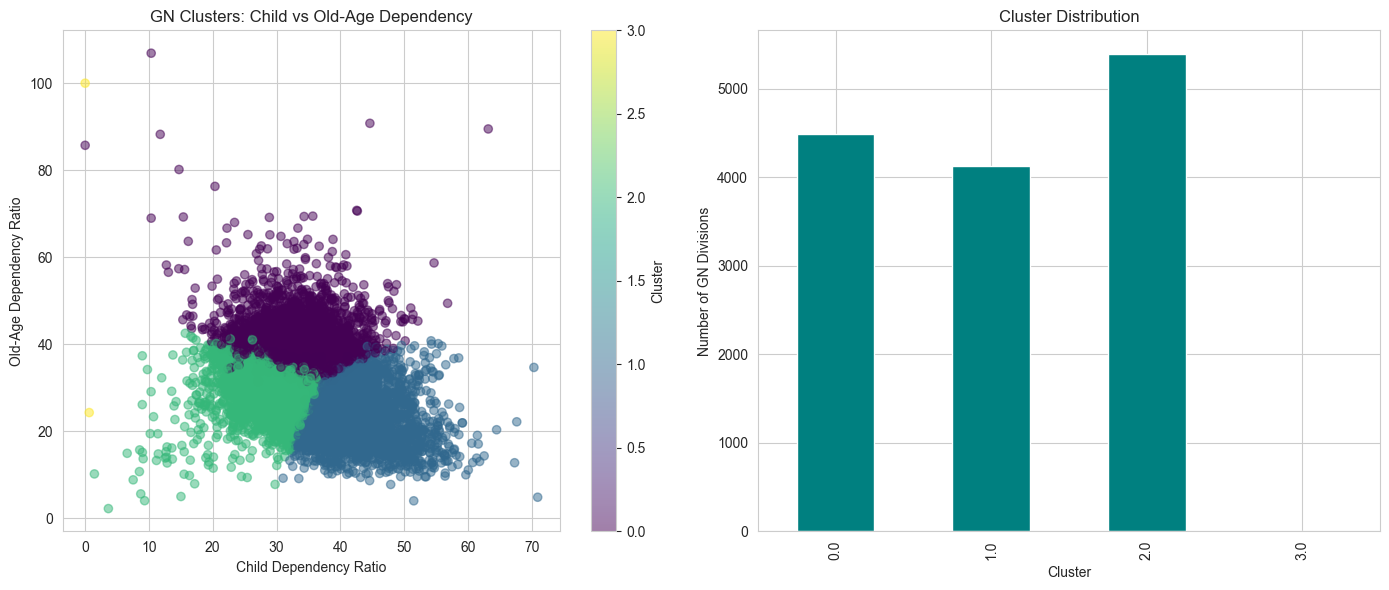

In [31]:
# Visualize Clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter = axes[0].scatter(df['Child_Dependency_Ratio'], df['Old_Age_Dependency_Ratio'], 
                          c=df['Cluster'], cmap='viridis', alpha=0.5)
axes[0].set_xlabel('Child Dependency Ratio')
axes[0].set_ylabel('Old-Age Dependency Ratio')
axes[0].set_title('GN Clusters: Child vs Old-Age Dependency')
plt.colorbar(scatter, ax=axes[0], label='Cluster')

df['Cluster'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='teal')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of GN Divisions')
axes[1].set_title('Cluster Distribution')

plt.tight_layout()
plt.savefig('cluster_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Resource Allocation Index

In [32]:
# Create Priority Scores (normalized to 0-100)
df['School_Priority'] = (df['Child_Dependency_Ratio'] / df['Child_Dependency_Ratio'].max()) * 100
df['ElderCare_Priority'] = (df['Old_Age_Dependency_Ratio'] / df['Old_Age_Dependency_Ratio'].max()) * 100

print("Top 15 GN Divisions for NEW SCHOOL Allocation:")
print(df.nlargest(15, 'School_Priority')[[gn_name_col, district_col, 'Child_Dependency_Ratio', 'School_Priority']].to_string(index=False))

print("\nTop 15 GN Divisions for NEW ELDER CARE FACILITY Allocation:")
print(df.nlargest(15, 'ElderCare_Priority')[[gn_name_col, district_col, 'Old_Age_Dependency_Ratio', 'ElderCare_Priority']].to_string(index=False))

Top 15 GN Divisions for NEW SCHOOL Allocation:
      GN_Division_Name District_Name  Child_Dependency_Ratio  School_Priority
        Air Force Camp       Gampaha               70.902394       100.000000
            Medakekila         Kandy               70.312500        99.168019
    Kakkayankulam East        Mannar               67.622951        95.374707
      Thimbiriettawala  Anuradhapura               67.285714        94.899072
        Palliyagodella   Polonnaruwa               64.467005        90.923594
Pungudutivu South East        Jaffna               63.157895        89.077239
           Weligollewa  Anuradhapura               62.519201        88.176432
             Oluvil 07        Ampara               61.808118        87.173528
       Razoolputhuveli        Mannar               61.594203        86.871824
              Melchena         Kandy               61.457233        86.678643
            Godigamuwa    Moneragala               61.348315        86.525026
             Pala

## 7. Anomaly Detection

In [33]:
# Calculate Z-scores for key metrics
df['Sex_Ratio_Zscore'] = np.abs(stats.zscore(df['Sex_Ratio'].fillna(df['Sex_Ratio'].median())))
df['Child_Dep_Zscore'] = np.abs(stats.zscore(df['Child_Dependency_Ratio'].fillna(0)))
df['Old_Age_Dep_Zscore'] = np.abs(stats.zscore(df['Old_Age_Dependency_Ratio'].fillna(0)))

# Anomalies: Z-score > 3
threshold = 3
anomalies = df[(df['Sex_Ratio_Zscore'] > threshold) | 
               (df['Child_Dep_Zscore'] > threshold) | 
               (df['Old_Age_Dep_Zscore'] > threshold)]

print(f"Detected {len(anomalies)} Anomalous GN Divisions (Z-score > {threshold}):")
print(anomalies[[gn_name_col, district_col, 'Sex_Ratio', 'Child_Dependency_Ratio', 'Old_Age_Dependency_Ratio']].head(20))

Detected 251 Anomalous GN Divisions (Z-score > 3):
        GN_Division_Name District_Name   Sex_Ratio  Child_Dependency_Ratio  \
22                Pettah       Colombo  894.915254                0.638298   
23                  Fort       Colombo  142.857143               24.496644   
33             Ibbanwala       Colombo  110.375494               11.991870   
94          Malabe North       Colombo  117.097264               14.248108   
132         Rajamalwatta       Colombo  110.097324               10.330912   
158        Panagoda East       Colombo   91.463415               51.485149   
192       Pitipana North       Colombo   84.897694               11.460873   
264      Weragolla South       Colombo  127.964602               27.823050   
371             Wijerama       Colombo   87.452471               10.718447   
372  Gangodavila South B       Colombo   53.455074               11.388152   
401        Borella North       Colombo  130.061702               18.731417   
492          

In [34]:
# Save Final Enhanced Dataset
final_cols = [c for c in df.columns if not c.endswith('_Zscore')]
df[final_cols].to_csv('GN_population_final_analysis.csv', index=False)
print("Final dataset saved to 'GN_population_final_analysis.csv'")
print(f"Total columns: {len(final_cols)}")

Final dataset saved to 'GN_population_final_analysis.csv'
Total columns: 25


---
## Summary

This analysis covered:
- **Sex Ratio Analysis**: Identified gender-imbalanced GNs
- **Dependency Ratios**: Child and Old-Age dependency per working population
- **K-Means Clustering**: Created demographic profiles (Aging Villages, Young Families, etc.)
- **Resource Allocation**: Ranked GNs for school and elder care prioritization
- **Anomaly Detection**: Flagged statistically unusual GN divisions

### Output Files:
- `GN_population_final_analysis.csv` - Full dataset with clusters and priorities
- PNG visualizations for reporting